# Project 1: Classification Analysis on Textual Data

### Classification Analysis on Textual Data 
#### Spring 2021

In [59]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines

### Part 1: TF-IDF

Load "20 Newsgroups" dataset. It is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. It is is splitted in two subsets: one for training (or development) and the other one for testing (or for performance evaluation) and is a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering.

In [60]:
from sklearn.datasets import fetch_20newsgroups
# Refer to the offcial document of scikit-learn for detailed usages:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
categories = ['comp.graphics', 'comp.sys.mac.hardware']
# The 
twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=None, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
#                                   remove=['headers'],
                                 )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [61]:
print(type(twenty_train.data))

<class 'list'>


In [64]:
twenty_train.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [63]:
np.unique(twenty_train.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [67]:
twenty_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [76]:
df = pd.DataFrame(data= np.c_[twenty_train['data'], twenty_train['target'], list(map(lambda x: twenty_train['target_names'][x], twenty_train['target']))],
                     columns= ['data', 'target', 'target_names'])
df.head(10)

,data,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


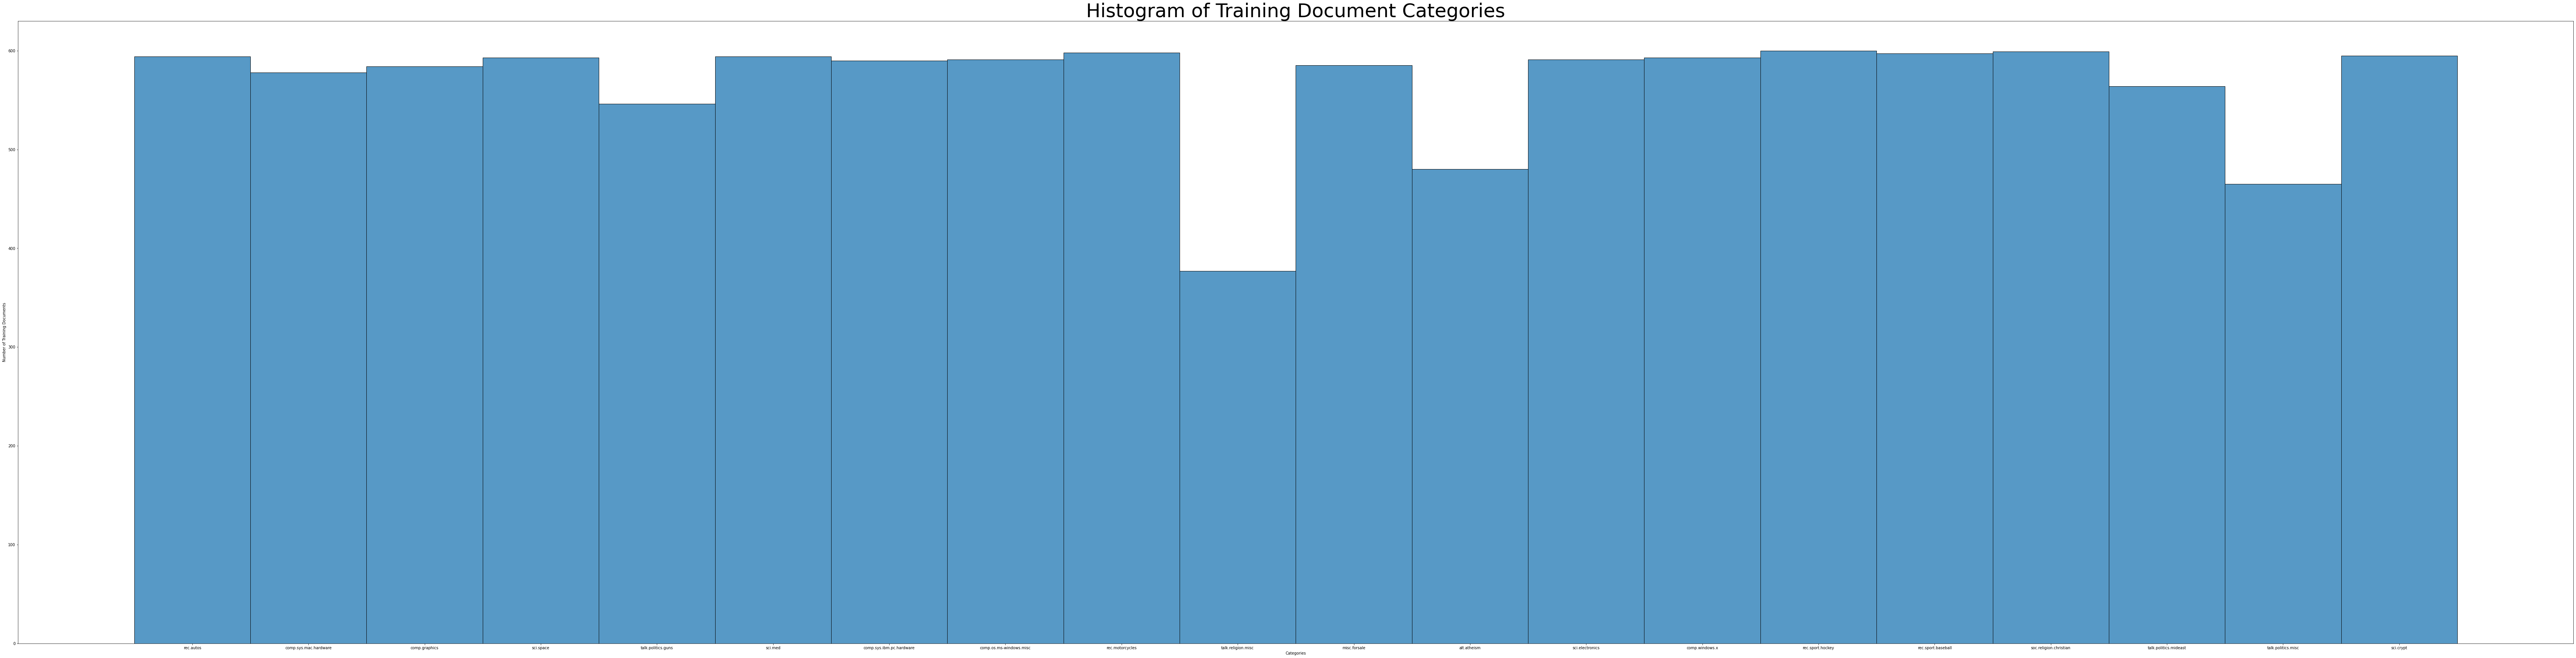

In [57]:
plt.figure(figsize=(120, 30))
ax = sns.histplot(data = df['target_names'])
ax.set(xlabel='Categories', ylabel='Number of Training Documents')
ax.axes.set_title('Histogram of Training Document Categories',fontsize=50)
plt.show()

In [68]:
data = pd.Series(twenty_train.data) 
data = pd.DataFrame(data) 
data.columns = ['Data'] + data.columns.tolist()[1:] 
data['target'] = pd.Series(twenty_train.target)
data.head(10)

,Data,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16
6,From: bmdelane@quads.uchicago.edu (brian manni...,13
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4


In [69]:
len(twenty_train.data)

11314

In [70]:
len(twenty_test.data)

774

In [92]:
data['target'] = data['target'].astype('int')

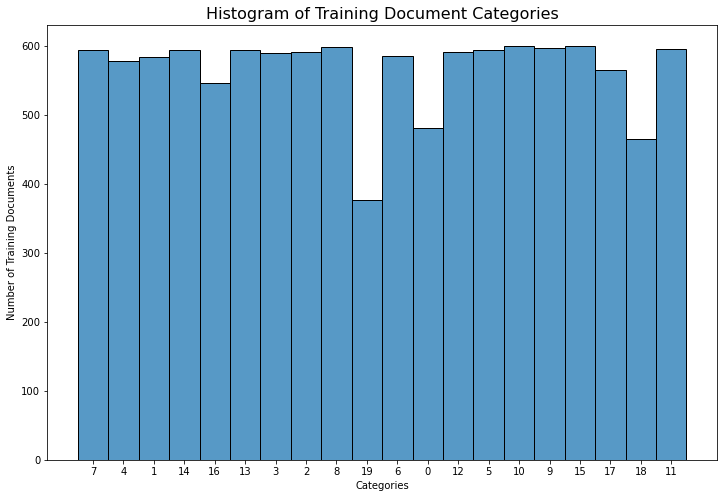

In [88]:
# plot histogram of # of trainings documents for each of the 20 categorues to check if they're evenly distributed
plt.figure(figsize=(12, 8))
order=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
ax = sns.histplot(data = data['target'])
ax.set(xlabel='Categories', ylabel='Number of Training Documents')
ax.axes.set_title('Histogram of Training Document Categories',fontsize=16)
plt.show()
#ax.figure.savefig("categoryhist.png")

Text(0.5, 0, 'Categories')

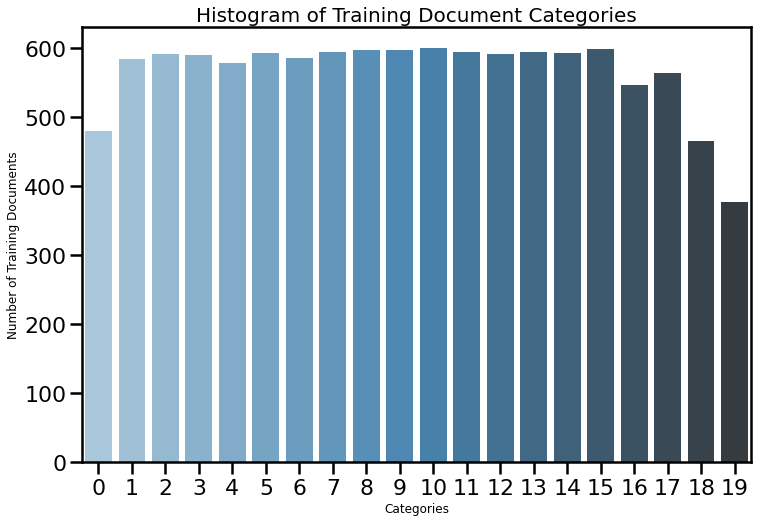

In [127]:
count_Categories = data['target'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=count_Categories.index, y=count_Categories.values,palette=("Blues_d"))
plt.title('Histogram of Training Document Categories', fontsize=20)
plt.ylabel('Number of Training Documents', fontsize=12)
plt.xlabel('Categories', fontsize=12)
#sns.set_context("poster")

#### The training documents are roughly evenly distributed as seen from the histogram above

### Part 2: Word Embedding

In [9]:
import nltk
import numpy as np
import pandas as pd
#from scipy import spatial
#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.manifold import TSNE
#from sklearn.preprocessing import StandardScaler
#from nltk.corpus import stopwords
#import re
#import string

In [7]:
#Create a key-value dictionary where key is the word and value is the word embedding
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

##### QUESTION 8: Read the paper about GLoVE embeddings - found here and answer the following subquestions: answered in report


In [ ]:
print(embeddings_dict['queen']-embeddings_dict['king']-embeddings_dict['wife']+embeddings_dict['husband'])

In [ ]:
print(embeddings_dict['queen']-embeddings_dict['king'])

In [ ]:
print(embeddings_dict['wife']-embeddings_dict['husband'])

In [8]:
print(embeddings_dict['computer'])

[-2.7628e-01  1.3999e-01  9.8519e-02 -6.4019e-01  3.1988e-02  1.0066e-01
 -1.8673e-01 -3.7129e-01  5.9740e-01 -2.0405e+00  2.2368e-01 -2.6314e-02
  7.2408e-01 -4.3829e-01  4.8886e-01 -3.5486e-03 -1.0006e-01 -3.0587e-01
 -1.5621e-01 -6.8136e-02  2.1104e-01  2.9287e-01 -8.8861e-02 -2.0462e-01
 -5.7602e-01  3.4526e-01  4.1390e-01  1.7917e-01  2.5143e-01 -2.2678e-01
 -1.0103e-01  1.4576e-01  2.0127e-01  3.1810e-01 -7.8907e-01 -2.2194e-01
 -2.4833e-01 -1.5103e-02 -2.0050e-01 -2.6441e-02  1.8551e-01  3.3782e-01
 -3.3543e-01  8.6117e-01 -4.7083e-02 -1.7009e-01  3.0438e-01  9.4119e-02
  3.2435e-01 -8.1171e-01  8.8966e-01 -3.9149e-01  1.6828e-01  1.4316e-01
  3.6339e-03 -6.4557e-02  4.5777e-02 -3.2248e-01  4.8943e-02  1.6817e-01
  6.8344e-02  5.4227e-01  1.2493e-01  6.9742e-01 -3.7194e-02  3.3080e-01
 -4.2194e-01  3.3970e-01  2.7646e-01 -1.6003e-02 -2.1827e-01  4.4535e-01
  3.5379e-01 -2.2089e-02  2.1375e-01  4.3267e-01 -3.2897e-01  9.6165e-02
  3.1265e-01 -3.0528e-01  2.6126e-01 -6.5364e-01 -7

## Feature Engineering: Stemming & Lemmatization

##### QUESTION 9: For the binary classification task distinguishing the “Computer Technology” class and “Recreational Activity” class:
1. Describe a feature engineering process that uses GLoVE word embeddings to represent each document. 
2. Select a classifier model, train and evaluate it with your GLoVE-based feature.





##### QUESTION 10: Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not?

##### QUESTION 11: Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots?

### Multiclass Classification

##### QUESTION 12: In this part, we aim to learn classifiers on the documents belonging to the classes: comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, misc.forsale, soc.religion.christian

Perform Naïve Bayes classification and multiclass SVM classification (with both One VS One and
One VS the rest methods described above) and report the confusion matrix and calculate the
accuracy, recall, precision and F-1 score of your classifiers.
